In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict

In [4]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [5]:
project: signac.Project = signac.init_project(name="2d-osc-shear", root=config['root'])
project.doc

{'avail_seed': 3, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [6]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float

In [63]:
# get d2min distribution

rev_quant = defaultdict(list)

for job in project:
    print(job)

    expers = sorted(glob.glob(job.fn("experiments/*/*/*")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp))
        
        # if float(period) != 1000.0:
        #     continue

        traj = gsd.hoomd.open(exper)

        print(max_shear, period, temp)

        # d2mins = []
        quants = []
        for i in range(1, 20):

            snap = traj[-1 + i*40]
            snap_high = traj[9 + i*40]
            snap_later = traj[-1 + (i+1)*40]
            snap_low = traj[29 + i*40]

            box = snap.configuration.box[:]
            box_high = snap_high.configuration.box[:]
            box_later = snap_later.configuration.box[:]
            box_low = snap_low.configuration.box[:]

            nlist_query = freud.locality.LinkCell.from_system(snap)
            nlist = nlist_query.query(snap.particles.position, {'num_neighbors': 10}).toNeighborList()

            d2min_irr = schmeud_rs.dynamics.d2min_frame(snap.particles.position[:, :2], snap_later.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box, box_later))
            d2min_rev = schmeud_rs.dynamics.d2min_frame(snap_high.particles.position[:, :2], snap_low.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box_high, box_low))
            quant = np.square(d2min_rev) - np.square(d2min_irr)
            quant = np.mean(quant > 0)
            quants.append(quant)
        rev_quant[sp].append(quants)

# save to pickle
with open(project.fn("results/rev-quant.pkl"), "wb") as f:
    pickle.dump(rev_quant, f)

634e14bc75836df75158fb15f379d8bb
0.01 100.0 0.0496
0.01 1000.0 0.0496
0.01 30.0 0.0496
0.01 300.0 0.0496
0.01 100.0 0.0992
0.01 1000.0 0.0992
0.01 30.0 0.0992
0.01 300.0 0.0992
0.01 100.0 0.1488
0.01 1000.0 0.1488
0.01 30.0 0.1488
0.01 300.0 0.1488
0.01 100.0 0.1984
0.01 1000.0 0.1984
0.01 30.0 0.1984
0.01 300.0 0.1984
0.02 100.0 0.0496
0.02 1000.0 0.0496
0.02 30.0 0.0496
0.02 300.0 0.0496
0.02 100.0 0.0992
0.02 1000.0 0.0992
0.02 30.0 0.0992
0.02 300.0 0.0992
0.02 100.0 0.1488
0.02 1000.0 0.1488
0.02 30.0 0.1488
0.02 300.0 0.1488
0.02 100.0 0.1984
0.02 1000.0 0.1984
0.02 30.0 0.1984
0.02 300.0 0.1984
0.03 100.0 0.0496
0.03 1000.0 0.0496
0.03 30.0 0.0496
0.03 300.0 0.0496
0.03 100.0 0.0992
0.03 1000.0 0.0992
0.03 30.0 0.0992
0.03 300.0 0.0992
0.03 100.0 0.1488
0.03 1000.0 0.1488
0.03 30.0 0.1488
0.03 300.0 0.1488
0.03 100.0 0.1984
0.03 1000.0 0.1984
0.03 30.0 0.1984
0.03 300.0 0.1984
0.05 100.0 0.0496
0.05 1000.0 0.0496
0.05 30.0 0.0496
0.05 300.0 0.0496
0.05 100.0 0.0992
0.05 1000.0 0

In [7]:
rev_quant = pickle.load(open(project.fn("results/rev-quant.pkl"), "rb"))

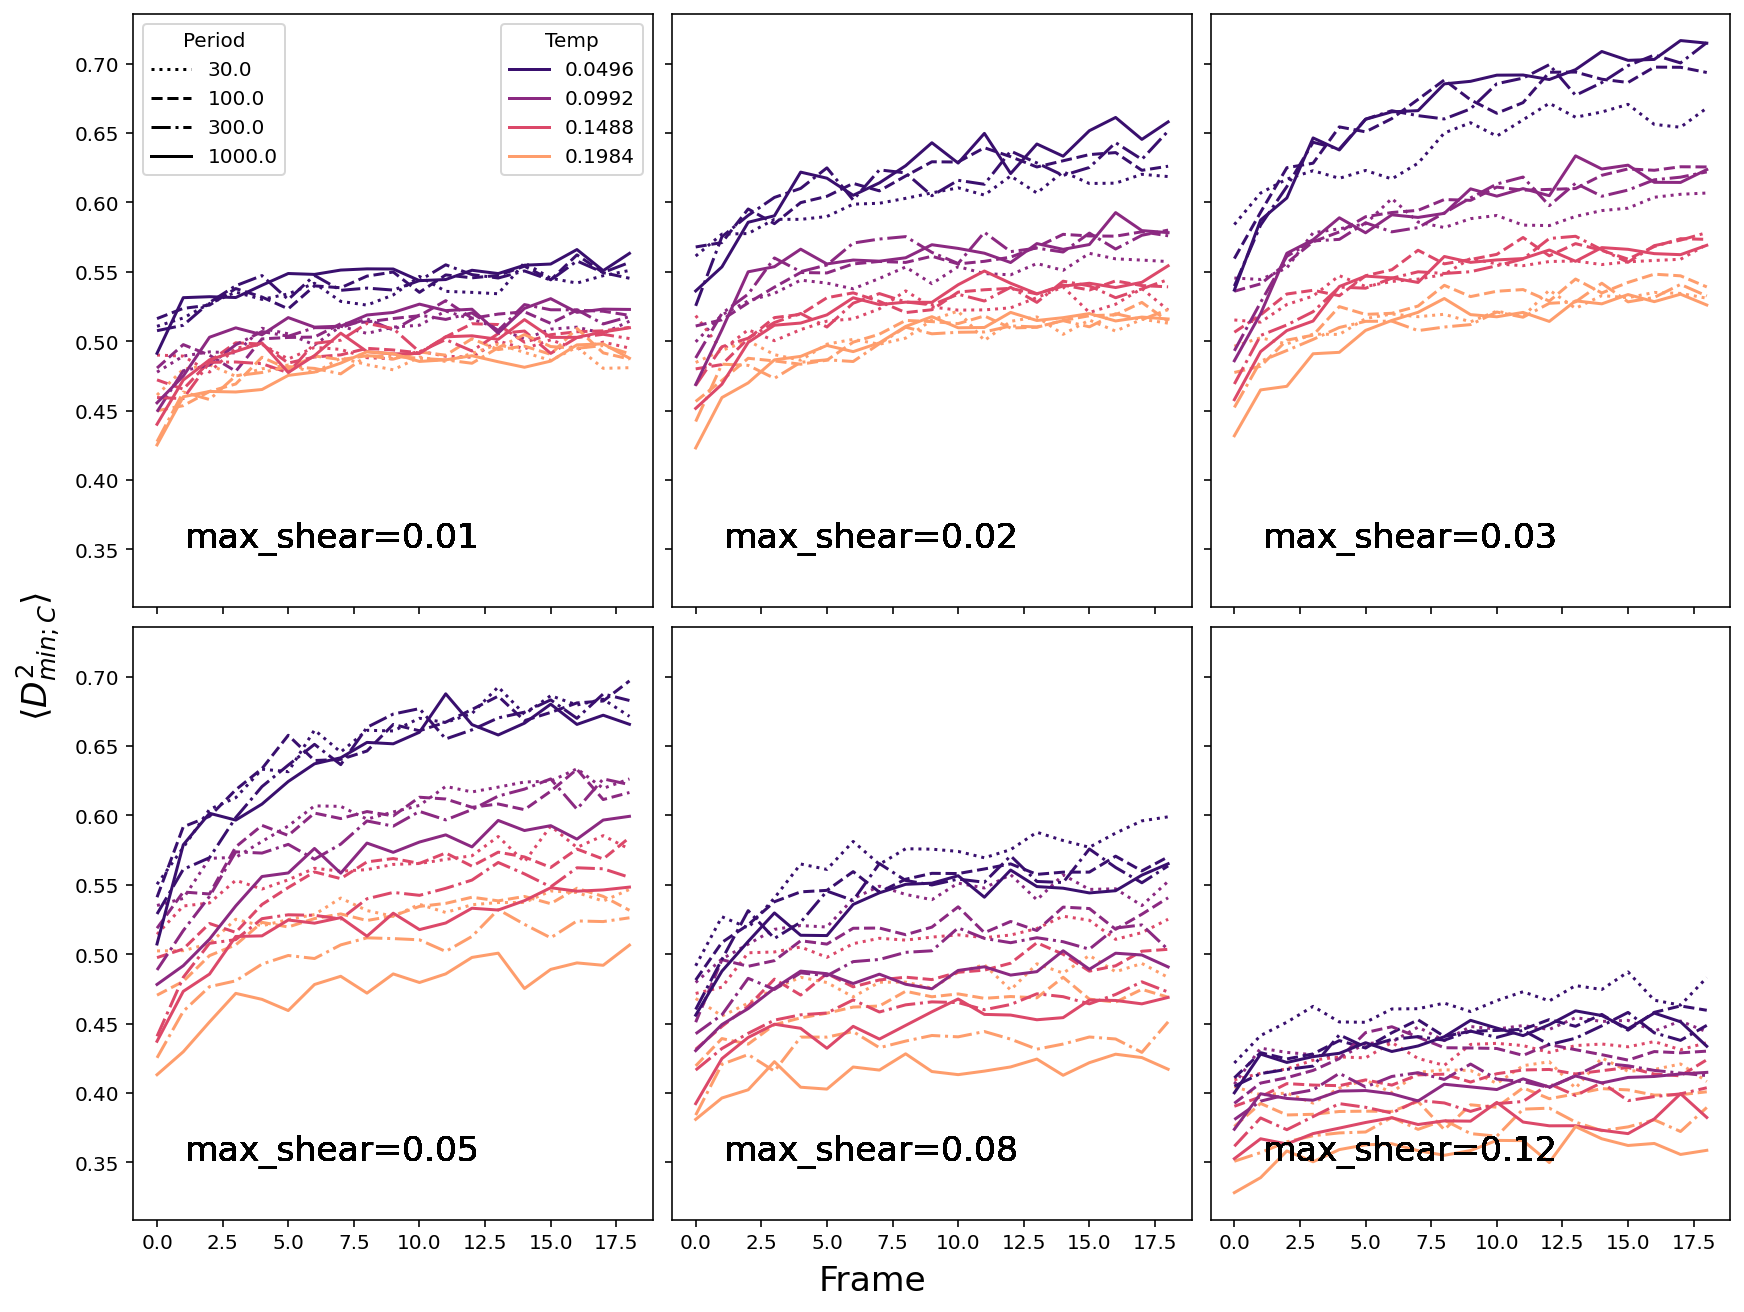

In [22]:
cmap = cm.magma
norm = colors.Normalize(vmin=0.0, vmax=0.25)

fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True, layout="constrained")

axs = axs.ravel()

# temp = 0.0496
# period = 1000.0
# max_shear = 0.03

lines = [':', '--', '-.', '-']
periods = [30.0, 100.0, 300.0, 1000.0]

idx = 0
for max_shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plt.sca(axs[idx])
    for period, line in zip(periods, lines):
        for k, v in rev_quant.items():
            if k.period != period or k.max_shear != max_shear:
                continue
            # print(k.temp)
            # print(np.array(v).shape)
            if line == '-':
                label = f"{k.temp:.4f}"
            else:
                label = None
            plt.plot(np.mean(np.array(v), axis=0), line, label=label, color=cmap(norm(k.temp)))
            plt.text(0.1, 0.1, f"{max_shear=:.2f}", transform=plt.gca().transAxes, size="xx-large")
    handles, labels = plt.gca().get_legend_handles_labels()
    order = np.argsort([float(label) for label in labels])
    if idx == 0:
        # make second legend with lines
        plot_lines = [plt.Line2D([0,0],[0,0], color='k', linestyle=line) for line in lines]
        lgd = plt.legend(plot_lines, periods, title="Period", loc=2)
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="Temp", loc=1, bbox_to_anchor=(1.0, 1.0))
        plt.gca().add_artist(lgd)
    idx += 1
# plt.xscale('log')
# plt.yscale('log')
fig.supylabel(r"$\langle D^2_{min;C} \rangle$", size="xx-large")
fig.supxlabel("Frame", size="xx-large")
# plt.title(f"{period=}, {max_shear=}")
plt.savefig(f"/home/ian/Pictures/rev-quant.png")

In [64]:
# get d2min distribution

rev_quant_2 = defaultdict(list)

for job in project:
    print(job)

    expers = sorted(glob.glob(job.fn("experiments/*/*/*")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp))
        
        # if float(period) != 1000.0:
        #     continue

        traj = gsd.hoomd.open(exper)

        print(max_shear, period, temp)

        # d2mins = []
        quants = []
        for i in range(1, 20):

            snap = traj[-1 + i*40]
            snap_high = traj[9 + i*40]
            snap_later = traj[-19 + i*40]
            snap_low = traj[29 + i*40]

            box = snap.configuration.box[:]
            box_high = snap_high.configuration.box[:]
            box_later = snap_later.configuration.box[:]
            box_low = snap_low.configuration.box[:]

            nlist_query = freud.locality.LinkCell.from_system(snap)
            nlist = nlist_query.query(snap.particles.position, {'num_neighbors': 10}).toNeighborList()

            d2min_irr = schmeud_rs.dynamics.d2min_frame(snap.particles.position[:, :2], snap_later.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box, box_later))
            d2min_rev = schmeud_rs.dynamics.d2min_frame(snap_high.particles.position[:, :2], snap_low.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box_high, box_low))
            quant = np.square(d2min_rev) - np.square(d2min_irr)
            quant = np.mean(quant > 0)
            quants.append(quant)
        rev_quant_2[sp].append(quants)

# save to pickle
with open(project.fn("results/rev-quant-2.pkl"), "wb") as f:
    pickle.dump(rev_quant_2, f)

634e14bc75836df75158fb15f379d8bb
0.01 100.0 0.0496
0.01 1000.0 0.0496
0.01 30.0 0.0496
0.01 300.0 0.0496
0.01 100.0 0.0992
0.01 1000.0 0.0992
0.01 30.0 0.0992
0.01 300.0 0.0992
0.01 100.0 0.1488
0.01 1000.0 0.1488
0.01 30.0 0.1488
0.01 300.0 0.1488
0.01 100.0 0.1984
0.01 1000.0 0.1984
0.01 30.0 0.1984
0.01 300.0 0.1984
0.02 100.0 0.0496
0.02 1000.0 0.0496
0.02 30.0 0.0496
0.02 300.0 0.0496
0.02 100.0 0.0992
0.02 1000.0 0.0992
0.02 30.0 0.0992
0.02 300.0 0.0992
0.02 100.0 0.1488
0.02 1000.0 0.1488
0.02 30.0 0.1488
0.02 300.0 0.1488
0.02 100.0 0.1984
0.02 1000.0 0.1984
0.02 30.0 0.1984
0.02 300.0 0.1984
0.03 100.0 0.0496
0.03 1000.0 0.0496
0.03 30.0 0.0496
0.03 300.0 0.0496
0.03 100.0 0.0992
0.03 1000.0 0.0992
0.03 30.0 0.0992
0.03 300.0 0.0992
0.03 100.0 0.1488
0.03 1000.0 0.1488
0.03 30.0 0.1488
0.03 300.0 0.1488
0.03 100.0 0.1984
0.03 1000.0 0.1984
0.03 30.0 0.1984
0.03 300.0 0.1984
0.05 100.0 0.0496
0.05 1000.0 0.0496
0.05 30.0 0.0496
0.05 300.0 0.0496
0.05 100.0 0.0992
0.05 1000.0 0

In [23]:
rev_quant_2 = pickle.load(open(project.fn("results/rev-quant-2.pkl"), "rb"))

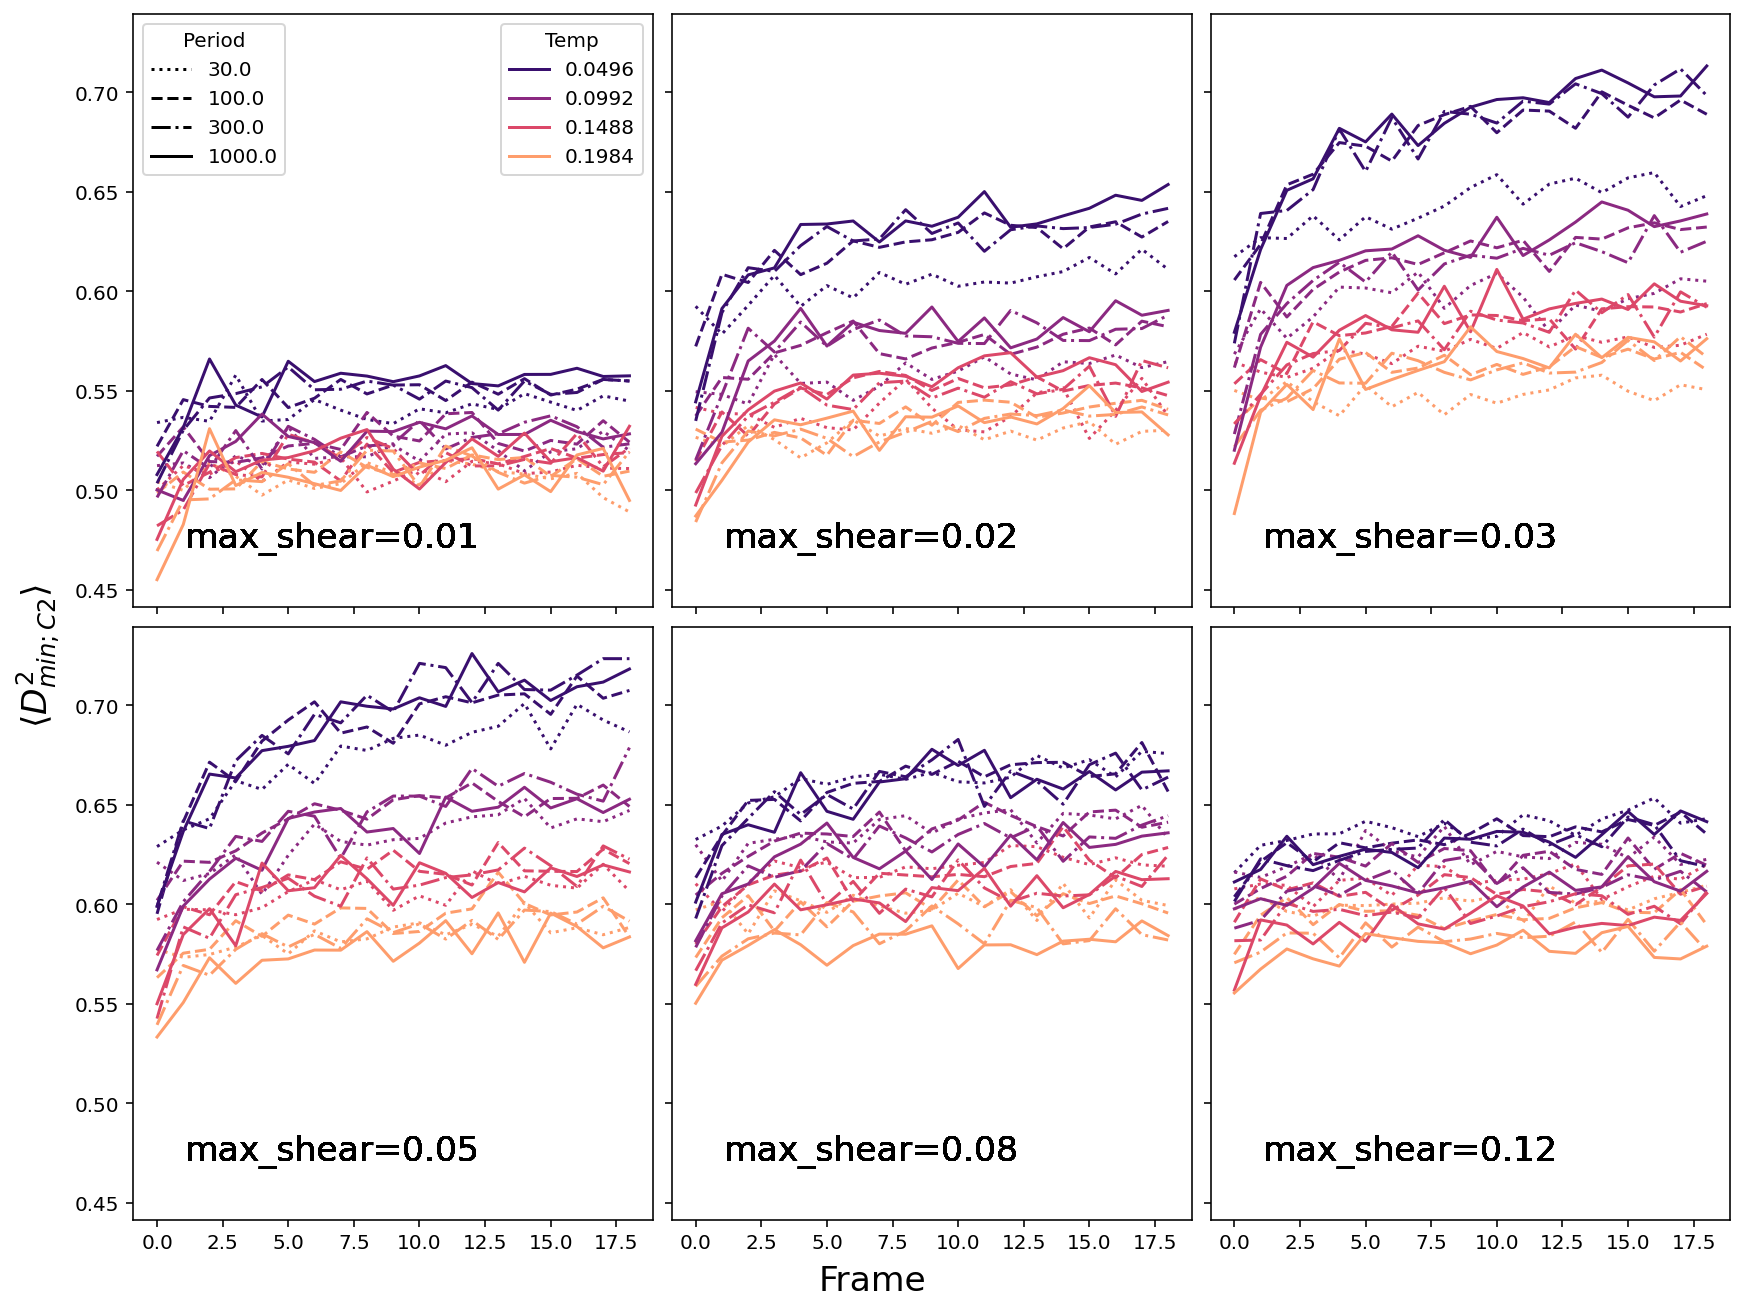

In [24]:
cmap = cm.magma
norm = colors.Normalize(vmin=0.0, vmax=0.25)

fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True, layout="constrained")

axs = axs.ravel()

# temp = 0.0496
# period = 1000.0
# max_shear = 0.03

lines = [':', '--', '-.', '-']
periods = [30.0, 100.0, 300.0, 1000.0]

idx = 0
for max_shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plt.sca(axs[idx])
    for period, line in zip(periods, lines):
        for k, v in rev_quant_2.items():
            if k.period != period or k.max_shear != max_shear:
                continue
            # print(k.temp)
            # print(np.array(v).shape)
            if line == '-':
                label = f"{k.temp:.4f}"
            else:
                label = None
            plt.plot(np.mean(np.array(v), axis=0), line, label=label, color=cmap(norm(k.temp)))
            plt.text(0.1, 0.1, f"{max_shear=:.2f}", transform=plt.gca().transAxes, size="xx-large")
    handles, labels = plt.gca().get_legend_handles_labels()
    order = np.argsort([float(label) for label in labels])
    if idx == 0:
        # make second legend with lines
        plot_lines = [plt.Line2D([0,0],[0,0], color='k', linestyle=line) for line in lines]
        lgd = plt.legend(plot_lines, periods, title="Period", loc=2)
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="Temp", loc=1, bbox_to_anchor=(1.0, 1.0))
        plt.gca().add_artist(lgd)
    idx += 1
# plt.xscale('log')
# plt.yscale('log')
fig.supylabel(r"$\langle D^2_{min;C2} \rangle$", size="xx-large")
fig.supxlabel("Frame", size="xx-large")
# plt.title(f"{period=}, {max_shear=}")
plt.savefig(f"/home/ian/Pictures/rev-quant-2.png")

In [17]:
plt.hist2d(d2min_irr, d2min_rev, norm=mpl.colors.LogNorm(), bins=[np.geomspace(d2min_irr.min(), d2min_irr.max(), 20), np.geomspace(d2min_rev.min(), d2min_rev.max(), 20)])
plt.xscale('log')
plt.yscale('log')
plt.ylabel("D2min rev")
plt.xlabel("D2min irr")

NameError: name 'd2min_irr' is not defined

In [65]:

autocorrs = defaultdict(list)

for job in project:
    print(job)

    expers = sorted(glob.glob(job.fn("experiments/*/*/*")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp))
        
        # if float(period) != 1000.0:
        #     continue

        traj = gsd.hoomd.open(exper)

        print(max_shear, period, temp)

        # d2mins = []
        last_d2min_irr = None
        last_d2min_rev = None
        autocorr_irr = []
        autocorr_rev = []
        for i in range(1, 20):

            snap = traj[-1 + i*40]
            snap_high = traj[9 + i*40]
            snap_later = traj[-1 + (i+1)*40]
            snap_low = traj[29 + i*40]

            box = snap.configuration.box[:]
            box_high = snap_high.configuration.box[:]
            box_later = snap_later.configuration.box[:]
            box_low = snap_low.configuration.box[:]

            nlist_query = freud.locality.LinkCell.from_system(snap)
            nlist = nlist_query.query(snap.particles.position, {'num_neighbors': 10}).toNeighborList()

            d2min_irr = schmeud_rs.dynamics.d2min_frame(snap.particles.position[:, :2], snap_later.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box, box_later))
            d2min_rev = schmeud_rs.dynamics.d2min_frame(snap_high.particles.position[:, :2], snap_low.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box_high, box_low))
            if last_d2min_irr is not None:
                autocorr_irr.append(stats.pearsonr(d2min_irr, last_d2min_irr)[0])
            last_d2min_irr = d2min_irr
            if last_d2min_rev is not None:
                autocorr_rev.append(stats.pearsonr(d2min_rev, last_d2min_rev)[0])
            last_d2min_rev = d2min_rev
        autocorrs[sp].append(np.array([autocorr_irr, autocorr_rev]))

# save to pickle
with open(project.fn("results/autocorrs.pkl"), "wb") as f:
    pickle.dump(autocorrs, f)

634e14bc75836df75158fb15f379d8bb
0.01 100.0 0.0496
0.01 1000.0 0.0496
0.01 30.0 0.0496
0.01 300.0 0.0496
0.01 100.0 0.0992
0.01 1000.0 0.0992
0.01 30.0 0.0992
0.01 300.0 0.0992
0.01 100.0 0.1488
0.01 1000.0 0.1488
0.01 30.0 0.1488
0.01 300.0 0.1488
0.01 100.0 0.1984
0.01 1000.0 0.1984
0.01 30.0 0.1984
0.01 300.0 0.1984
0.02 100.0 0.0496
0.02 1000.0 0.0496
0.02 30.0 0.0496
0.02 300.0 0.0496
0.02 100.0 0.0992
0.02 1000.0 0.0992
0.02 30.0 0.0992
0.02 300.0 0.0992
0.02 100.0 0.1488
0.02 1000.0 0.1488
0.02 30.0 0.1488
0.02 300.0 0.1488
0.02 100.0 0.1984
0.02 1000.0 0.1984
0.02 30.0 0.1984
0.02 300.0 0.1984
0.03 100.0 0.0496
0.03 1000.0 0.0496
0.03 30.0 0.0496
0.03 300.0 0.0496
0.03 100.0 0.0992
0.03 1000.0 0.0992
0.03 30.0 0.0992
0.03 300.0 0.0992
0.03 100.0 0.1488
0.03 1000.0 0.1488
0.03 30.0 0.1488
0.03 300.0 0.1488
0.03 100.0 0.1984
0.03 1000.0 0.1984
0.03 30.0 0.1984
0.03 300.0 0.1984
0.05 100.0 0.0496
0.05 1000.0 0.0496
0.05 30.0 0.0496
0.05 300.0 0.0496
0.05 100.0 0.0992
0.05 1000.0 0

In [25]:
autocorrs = pickle.load(open(project.fn("results/autocorrs.pkl"), "rb"))

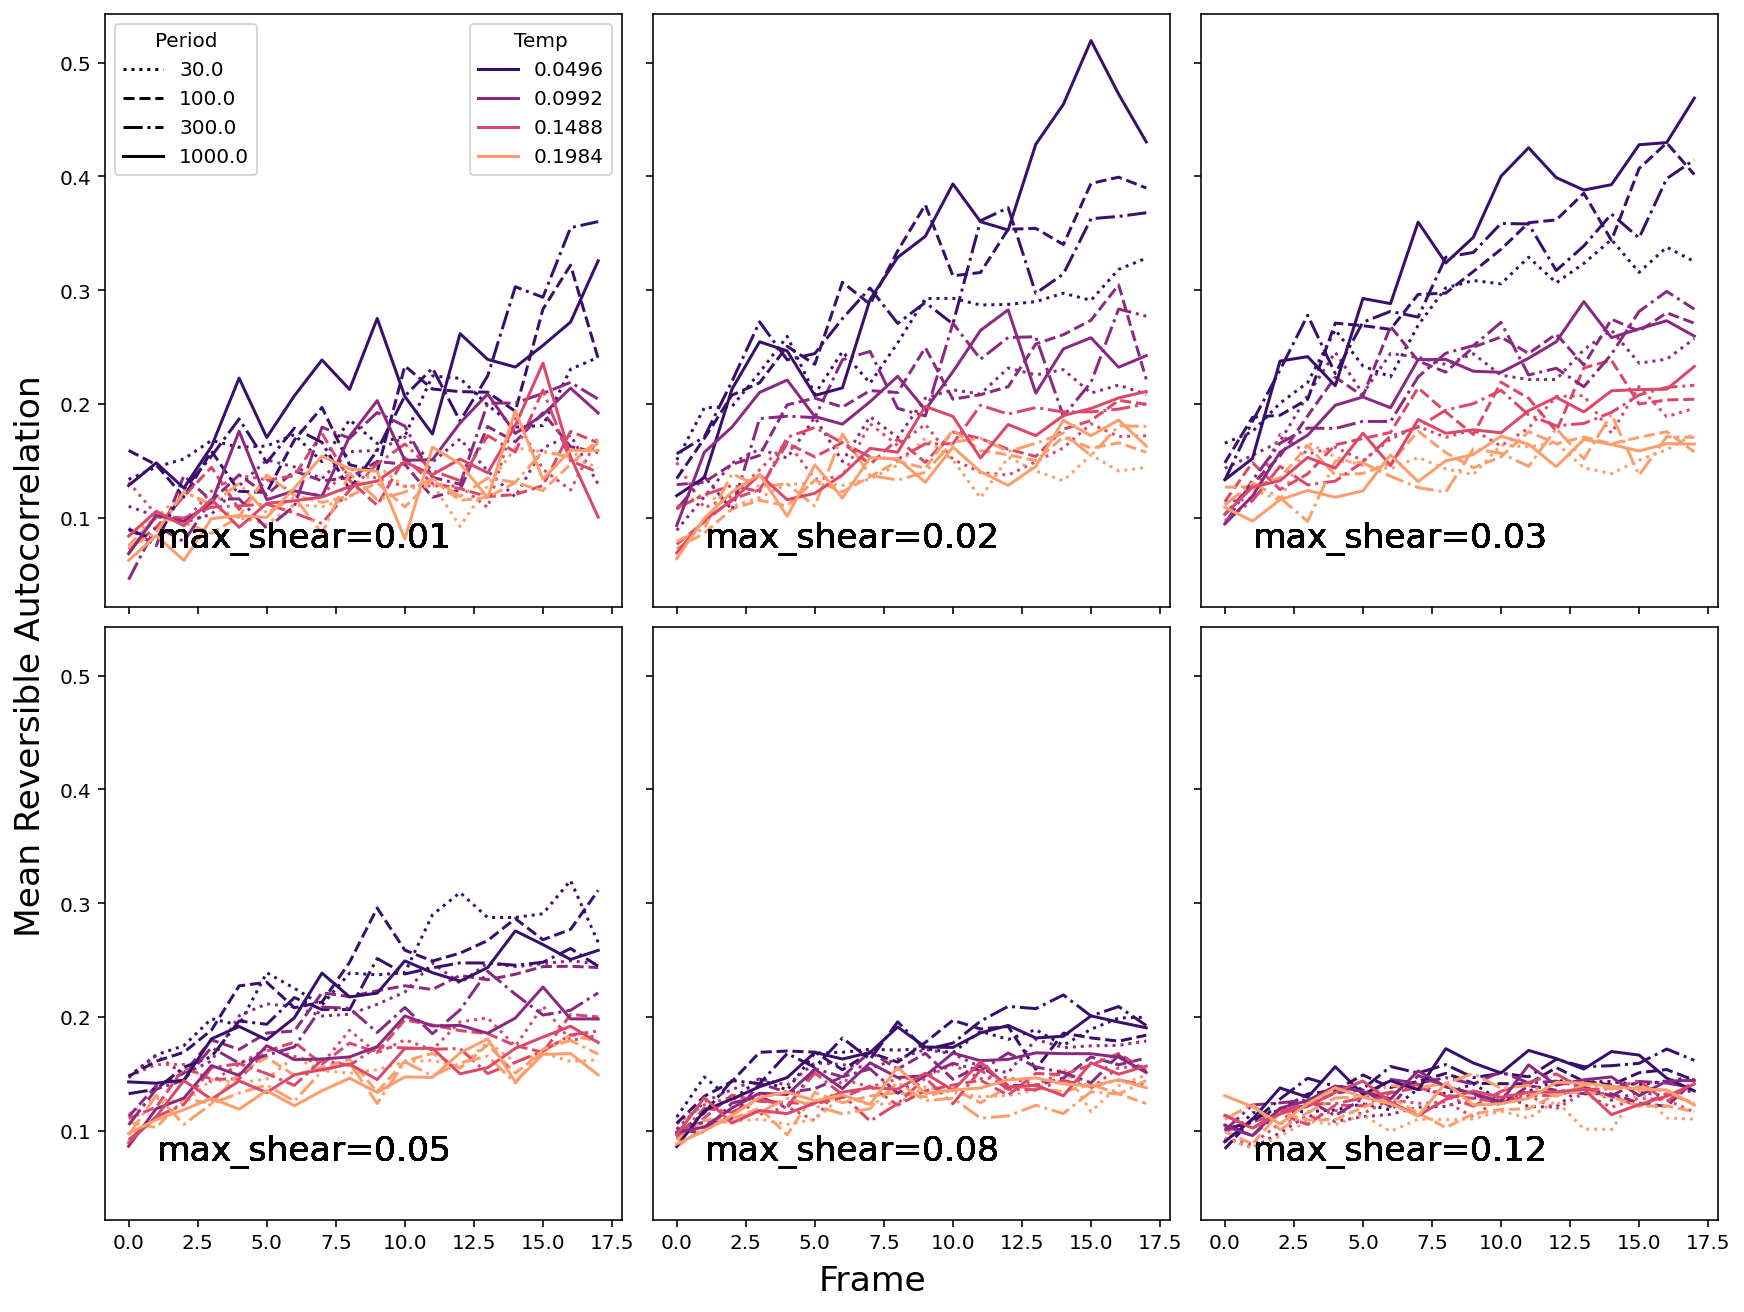

In [32]:
cmap = cm.magma
norm = colors.Normalize(vmin=0.0, vmax=0.25)

fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True, layout="constrained")

axs = axs.ravel()

# temp = 0.0496
# period = 1000.0
# max_shear = 0.03

lines = [':', '--', '-.', '-']
periods = [30.0, 100.0, 300.0, 1000.0]

idx = 0
for max_shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plt.sca(axs[idx])
    for period, line in zip(periods, lines):
        for k, v in autocorrs.items():
            if k.period != period or k.max_shear != max_shear:
                continue
            # print(k.temp)
            # print(np.array(v).shape)
            if line == '-':
                label = f"{k.temp:.4f}"
            else:
                label = None
            plt.plot(np.mean(np.array(v)[:,1], axis=0), line, label=label, color=cmap(norm(k.temp)))
            plt.text(0.1, 0.1, f"{max_shear=:.2f}", transform=plt.gca().transAxes, size="xx-large")
    handles, labels = plt.gca().get_legend_handles_labels()
    order = np.argsort([float(label) for label in labels])
    if idx == 0:
        # make second legend with lines
        plot_lines = [plt.Line2D([0,0],[0,0], color='k', linestyle=line) for line in lines]
        lgd = plt.legend(plot_lines, periods, title="Period", loc=2)
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="Temp", loc=1, bbox_to_anchor=(1.0, 1.0))
        plt.gca().add_artist(lgd)
    idx += 1
# plt.xscale('log')
# plt.yscale('log')
fig.supylabel("Mean Reversible Autocorrelation", size="xx-large")
fig.supxlabel("Frame", size="xx-large")
# plt.title(f"{period=}, {max_shear=}")
plt.savefig(f"/home/ian/Pictures/autocorr-rev.png")

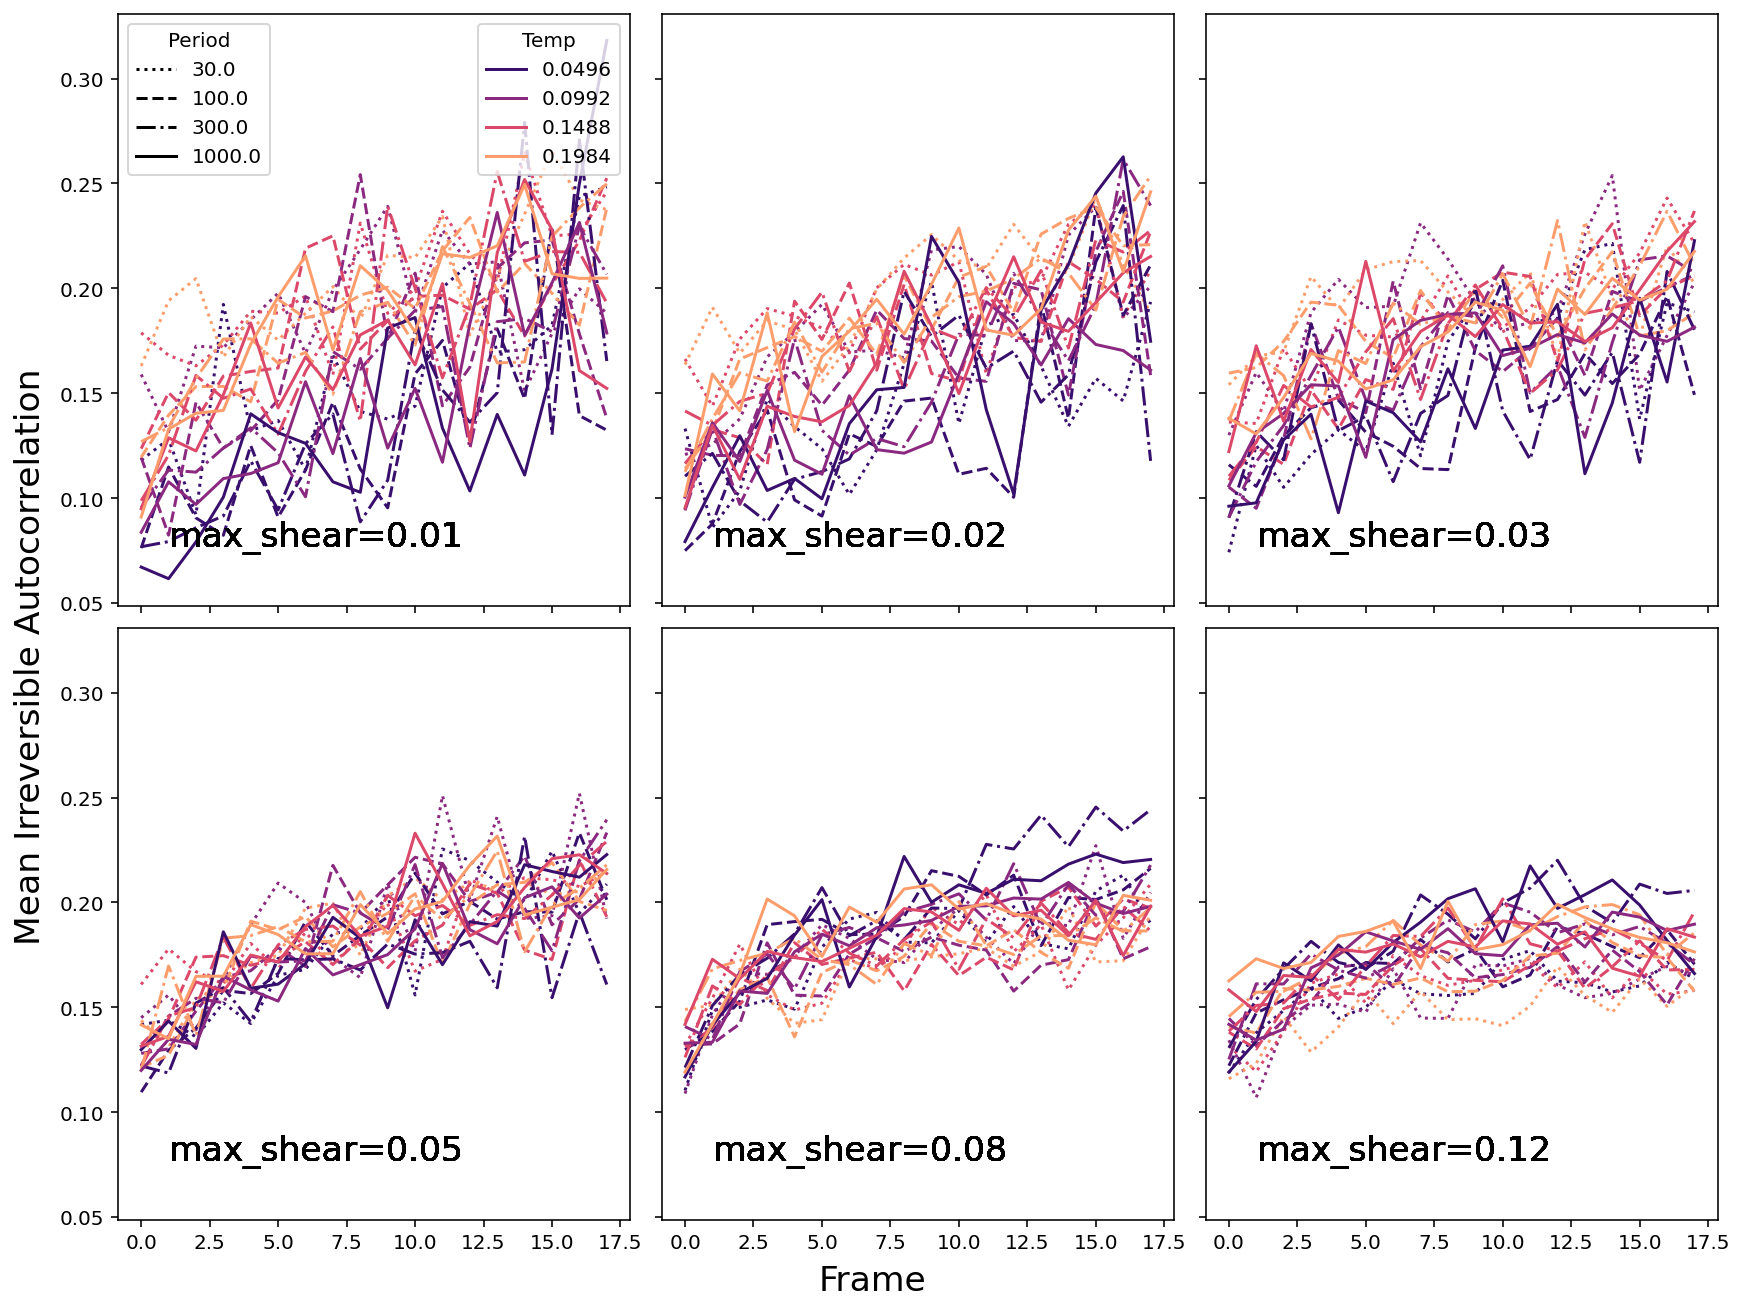

In [33]:
cmap = cm.magma
norm = colors.Normalize(vmin=0.0, vmax=0.25)

fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True, layout="constrained")

axs = axs.ravel()

# temp = 0.0496
# period = 1000.0
# max_shear = 0.03

lines = [':', '--', '-.', '-']
periods = [30.0, 100.0, 300.0, 1000.0]

idx = 0
for max_shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plt.sca(axs[idx])
    for period, line in zip(periods, lines):
        for k, v in autocorrs.items():
            if k.period != period or k.max_shear != max_shear:
                continue
            # print(k.temp)
            # print(np.array(v).shape)
            if line == '-':
                label = f"{k.temp:.4f}"
            else:
                label = None
            plt.plot(np.mean(np.array(v)[:,0], axis=0), line, label=label, color=cmap(norm(k.temp)))
            plt.text(0.1, 0.1, f"{max_shear=:.2f}", transform=plt.gca().transAxes, size="xx-large")
    handles, labels = plt.gca().get_legend_handles_labels()
    order = np.argsort([float(label) for label in labels])
    if idx == 0:
        # make second legend with lines
        plot_lines = [plt.Line2D([0,0],[0,0], color='k', linestyle=line) for line in lines]
        lgd = plt.legend(plot_lines, periods, title="Period", loc=2)
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="Temp", loc=1, bbox_to_anchor=(1.0, 1.0))
        plt.gca().add_artist(lgd)
    idx += 1
# plt.xscale('log')
# plt.yscale('log')
fig.supylabel("Mean Irreversible Autocorrelation", size="xx-large")
fig.supxlabel("Frame", size="xx-large")
# plt.title(f"{period=}, {max_shear=}")
plt.savefig(f"/home/ian/Pictures/autocorr-irr.png")

In [66]:
# get stroboscopic d2min

mean_d2mins = defaultdict(list)

for job in project:
    print(job)

    expers = sorted(glob.glob(job.fn("experiments/*/*/*")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        traj = gsd.hoomd.open(exper)
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp))

        d2mins = []
        for i in range(1, 20):

            snap = traj[-1 + i*40]
            snap_later = traj[-1 + (i+1)*40]

            box = snap.configuration.box[:]
            box_later = snap_later.configuration.box[:]

            nlist_query = freud.locality.LinkCell.from_system(snap)
            nlist = nlist_query.query(snap.particles.position, {'num_neighbors': 10}).toNeighborList()

            d2min = schmeud_rs.dynamics.d2min_frame(snap.particles.position[:, :2], snap_later.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box, box_later))
            d2mins.append(np.mean(d2min))
        mean_d2mins[sp].append(d2mins)

# save to pickle
with open(project.fn("results/mean-d2mins.pkl"), "wb") as f:
    pickle.dump(mean_d2mins, f)

634e14bc75836df75158fb15f379d8bb
cfa1e4c0007fd65d020f809715a6f0b4
6976a7c10ada4159010403f8027f3ea5


In [34]:
mean_d2mins = pickle.load(open(project.fn("results/mean-d2mins.pkl"), "rb"))

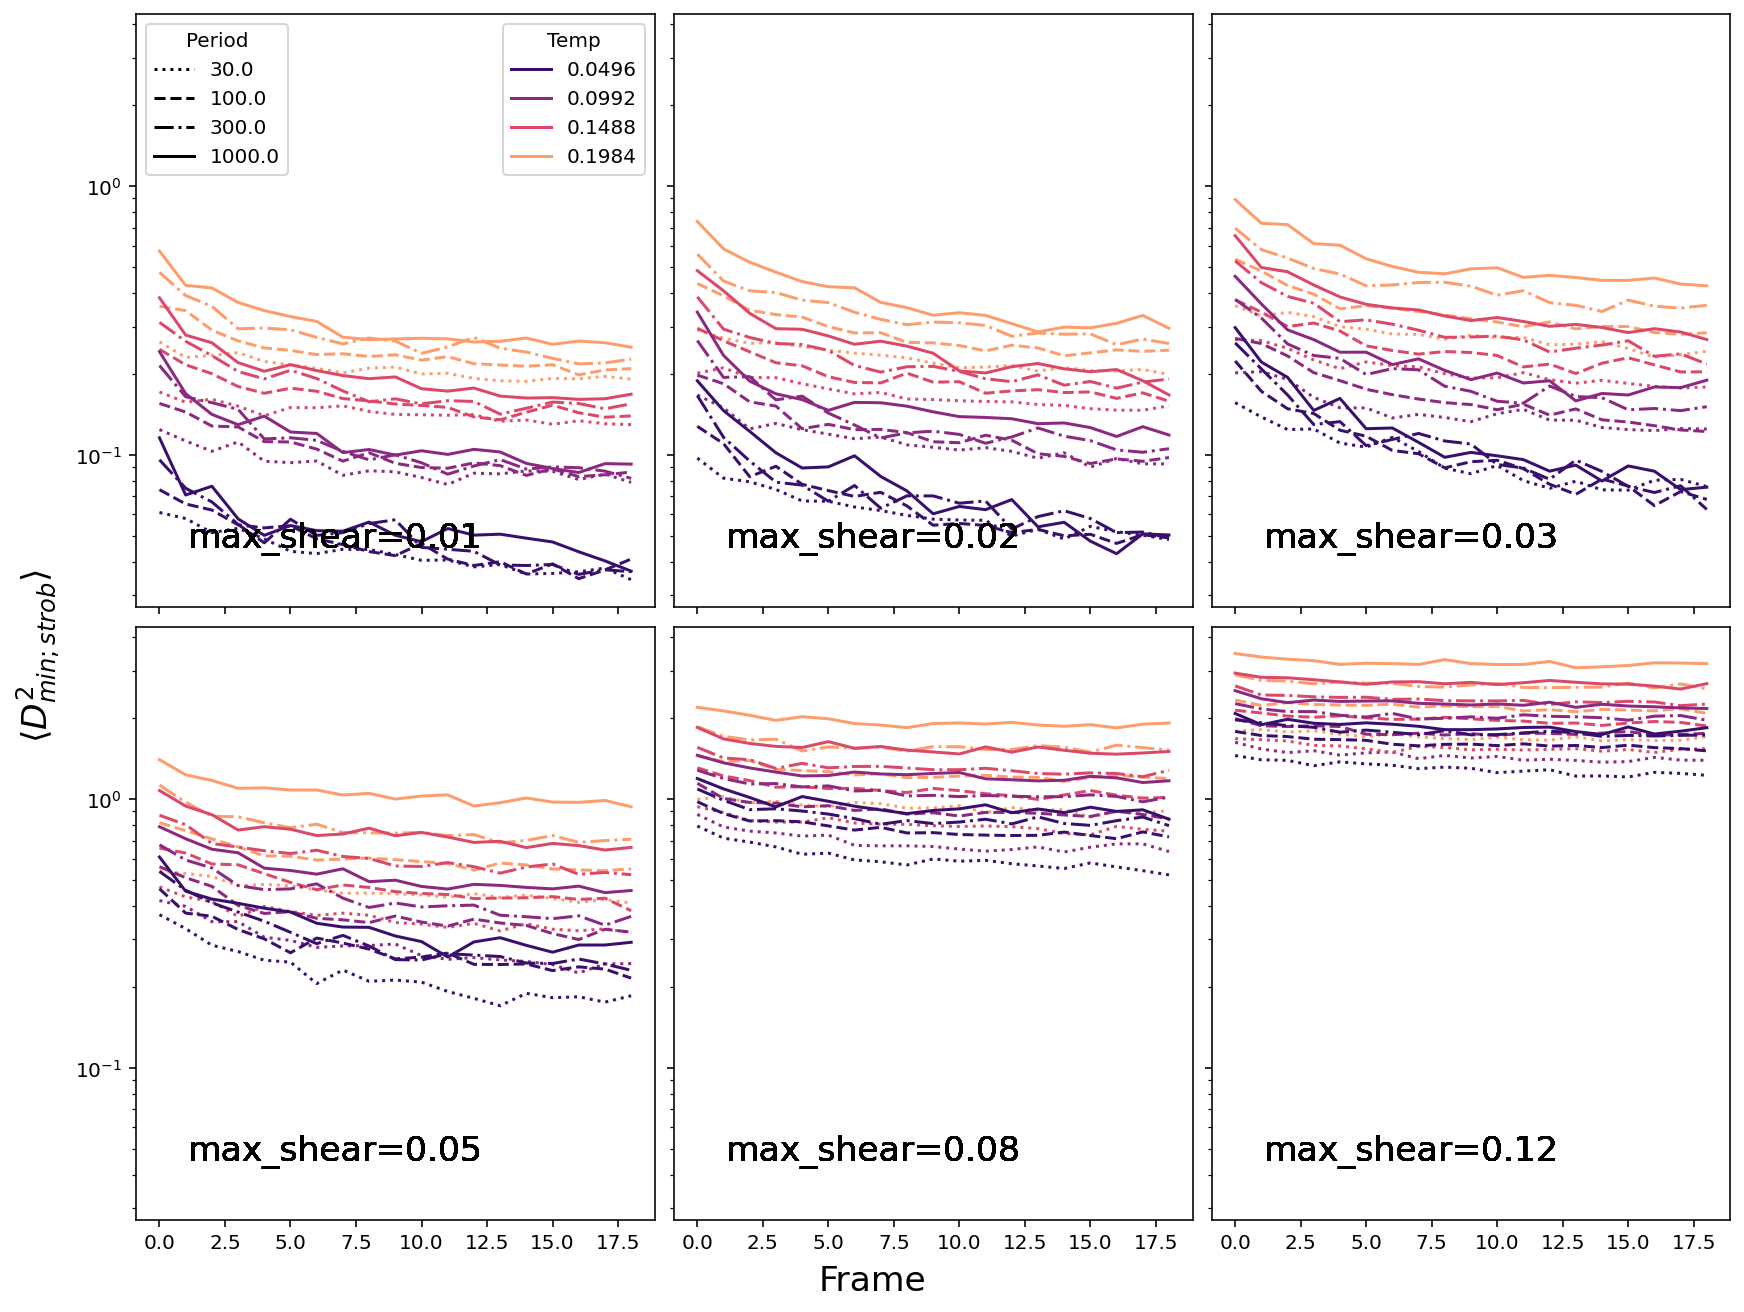

In [37]:
cmap = cm.magma
norm = colors.Normalize(vmin=0.0, vmax=0.25)

fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True, layout="constrained")

axs = axs.ravel()

# temp = 0.0496
# period = 1000.0
# max_shear = 0.03

lines = [':', '--', '-.', '-']
periods = [30.0, 100.0, 300.0, 1000.0]

idx = 0
for max_shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plt.sca(axs[idx])
    for period, line in zip(periods, lines):
        for k, v in mean_d2mins.items():
            if k.period != period or k.max_shear != max_shear:
                continue
            # print(k.temp)
            # print(np.array(v).shape)
            if line == '-':
                label = f"{k.temp:.4f}"
            else:
                label = None
            plt.plot(np.mean(np.array(v), axis=0), line, label=label, color=cmap(norm(k.temp)))
            plt.text(0.1, 0.1, f"{max_shear=:.2f}", transform=plt.gca().transAxes, size="xx-large")
    handles, labels = plt.gca().get_legend_handles_labels()
    order = np.argsort([float(label) for label in labels])
    if idx == 0:
        # make second legend with lines
        plot_lines = [plt.Line2D([0,0],[0,0], color='k', linestyle=line) for line in lines]
        lgd = plt.legend(plot_lines, periods, title="Period", loc=2)
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="Temp", loc=1, bbox_to_anchor=(1.0, 1.0))
        plt.gca().add_artist(lgd)
    idx += 1
# plt.xscale('log')
plt.yscale('log')
fig.supylabel(r"$\langle D^2_{min;strob} \rangle$", size="xx-large")
fig.supxlabel("Frame", size="xx-large")
# plt.title(f"{period=}, {max_shear=}")
plt.savefig(f"/home/ian/Pictures/mean_d2min-log.png")

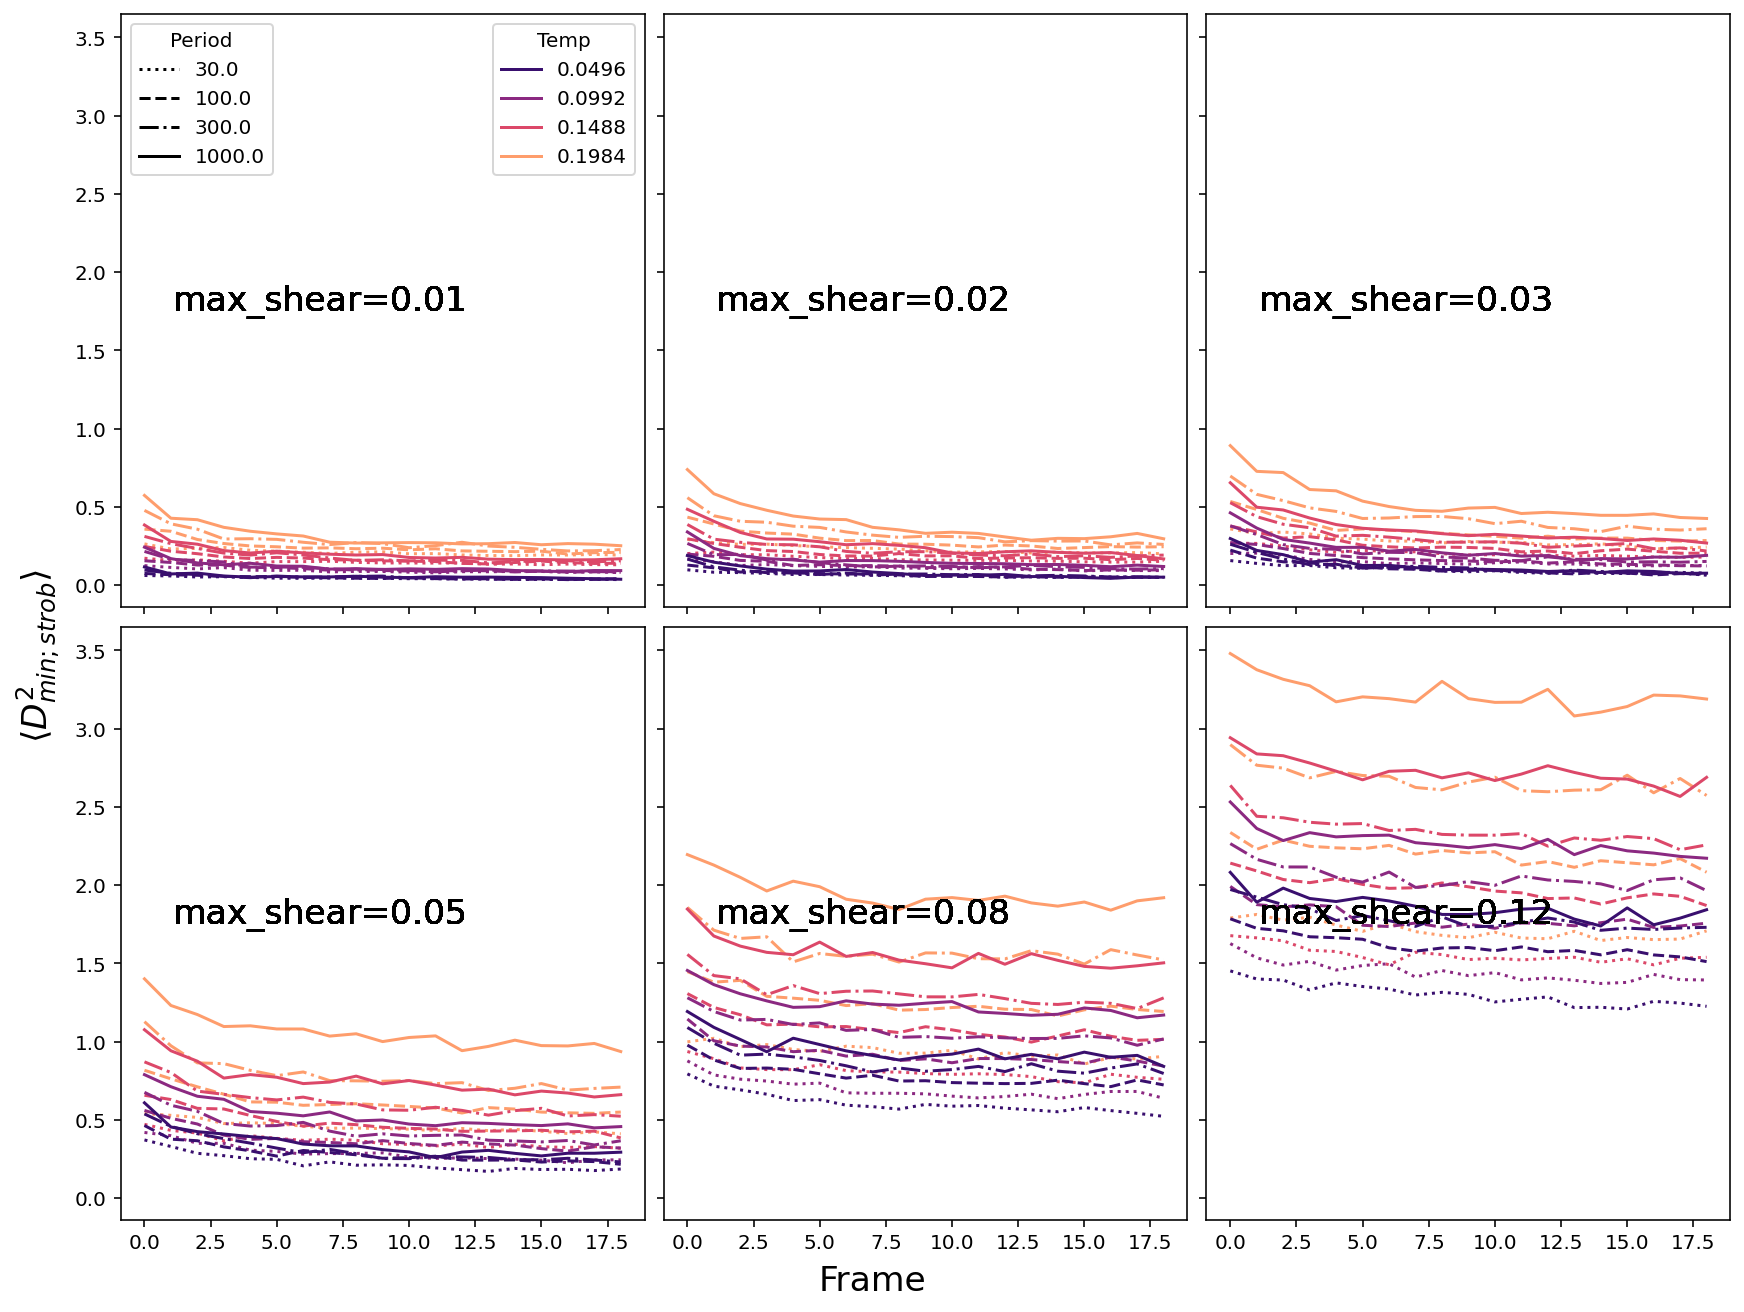

In [41]:
cmap = cm.magma
norm = colors.Normalize(vmin=0.0, vmax=0.25)

fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True, layout="constrained")

axs = axs.ravel()

# temp = 0.0496
# period = 1000.0
# max_shear = 0.03

lines = [':', '--', '-.', '-']
periods = [30.0, 100.0, 300.0, 1000.0]

idx = 0
for max_shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plt.sca(axs[idx])
    for period, line in zip(periods, lines):
        for k, v in mean_d2mins.items():
            if k.period != period or k.max_shear != max_shear:
                continue
            # print(k.temp)
            # print(np.array(v).shape)
            if line == '-':
                label = f"{k.temp:.4f}"
            else:
                label = None
            plt.plot(np.mean(np.array(v), axis=0), line, label=label, color=cmap(norm(k.temp)))
            plt.text(0.1, 0.5, f"{max_shear=:.2f}", transform=plt.gca().transAxes, size="xx-large")
    handles, labels = plt.gca().get_legend_handles_labels()
    order = np.argsort([float(label) for label in labels])
    if idx == 0:
        # make second legend with lines
        plot_lines = [plt.Line2D([0,0],[0,0], color='k', linestyle=line) for line in lines]
        lgd = plt.legend(plot_lines, periods, title="Period", loc=2)
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="Temp", loc=1, bbox_to_anchor=(1.0, 1.0))
        plt.gca().add_artist(lgd)
    idx += 1
# plt.xscale('log')
# plt.yscale('log')
fig.supylabel(r"$\langle D^2_{min;strob} \rangle$", size="xx-large")
fig.supxlabel("Frame", size="xx-large")
# plt.title(f"{period=}, {max_shear=}")
plt.savefig(f"/home/ian/Pictures/mean_d2min.png")

0.0496
0.0992
0.1488
0.1984


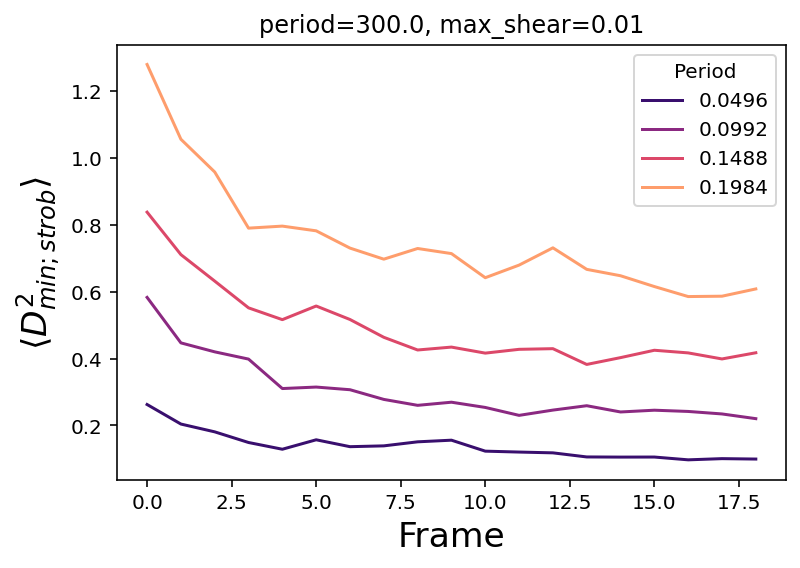

In [ ]:
cmap = cm.magma
norm = colors.Normalize(vmin=0.0, vmax=0.25)

# temp = 0.0496
period = 300.0
max_shear = 0.01

for k, v in mean_d2mins.items():
    if k.period != period or k.max_shear != max_shear:
        continue
    print(k.temp)
    plt.plot(np.mean(v, axis=0), label=f"{k.temp:.4f}", color=cmap(norm(k.temp)))
handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort([float(label) for label in labels])
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="Period")
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel(r"$\langle D^2_{min;strob} \rangle$", size="xx-large")
plt.xlabel("Frame", size="xx-large")
plt.title(f"{period=}, {max_shear=}")
plt.savefig(f"/home/ian/Pictures/strob_d2min-{period=}-{max_shear=}.png")

In [ ]:
job.doc

{'init': True, 'seed': 1, 'init_temp': 1.5, 'tg': 0.19836457263395846, 'temps': [0.049591143158489615, 0.09918228631697923, 0.14877342947546884, 0.19836457263395846], 'initialized': True, 'experiment_completed': True}